## Programming Exercise 4: Neural Networks Learning

#### Setup

In [62]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import Image

data = loadmat('ex4data1.mat')
weights = loadmat('ex4weights.mat')

In [63]:
# Padded with the ones at the beggining
X, y = np.c_[np.ones((data['X'].shape[0],1)), data['X']], data['y'] 
# Showing that the weights contains theta1 and theta2
weights.keys()

['Theta2', '__version__', '__header__', 'Theta1', '__globals__']

#### Displaying the Data

In [67]:
def display_data(x):
    im_number = 200
    imv = np.empty((20,0))
    imag = []
    for i in range(im_number):
        im = np.reshape(x[i],(20,20)).T
        imv = np.append(imv,im,axis=1)
        if (i+1) % 20 == 0:
            imag.append(imv)
            imv = np.empty((20,0))
    image = np.concatenate((imag[:]),axis = 0)
    plt.axis('off')
    plt.imshow(image, cmap = 'gray_r')

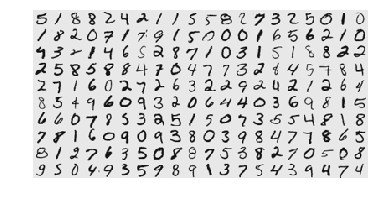

In [68]:
np.random.shuffle(data['X'])
display_data(data['X'])

#### Model Representation
Taken from the assignment's documentation:

![Model](img/Neural_Network_Model.png)

#### Cost Function

In [75]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def sigmoid_gradient(x):
    return sigmoid(x) * (1 - sigmoid(x))

def nn_cost_function(nn_params, num_labels, X, y, reg):
    # Extracting the Thetas
    theta1 = nn_params['Theta1']
    theta2 = nn_params['Theta2']
    
    # Setuping some variables
    m = X.shape[0]
    J = 0
    theta1_grad = np.zeros((theta1.shape))
    theta2_grad = np.zeros((theta2.shape))
    
    # Regularization Function for the Cost
    regfunc = float(reg) / (2. * m) * (np.square(theta1).sum() + np.square(theta2).sum())
    
    # FF neural network
    ## Since X is already padded with 1 we don't need to add ones
    a1 = X 
    ## Calculating the Hidden Layer
    a2 = sigmoid(X.dot(theta1.T))
    ## Then adding 1s
    a2 = np.c_[np.ones((a2.shape[0],1)), a2]
    ## Calculating the hypothesis
    h_thx = sigmoid(a2.dot(theta2.T))
    
    # Calculating the Cost Function
    for label in xrange(num_labels):
        y_label = y == label + 1 # since python indexing starts from 0
        h = h_thx[:,label].reshape(-1,1)
        J_label = - 1. / m * (np.log(h).T.dot(y_label) + np.log(1 - h).T.dot(1 - y_label))
        J = J + J_label

    
    # Backpropagation
    
    # Some initial allocations to make it easier
    delta_3 = np.zeros((num_labels, 1))
    delta_2 = np.zeros((theta2.shape[1],1))
    z2 = a1.dot(theta1.T)
    
    # -- for each sample point
    for t in xrange(m):
        for label in xrange(num_labels):
            y_label = y[t,:] == label + 1
            delta_3[label,:] = h_thx[t, label] - y_label
            
        delta_2 = theta2.T.dot(delta_3) * sigmoid_gradient(np.insert(z2[t,:], 0, 1.)).reshape(-1,1)
        # Removing the first delta_2 value as it is to connected to +1
        delta_2 = delta_2[1:,:]
        
        theta1_grad = theta1_grad + delta_2.dot(a1[t,:].reshape(-1,1).T)
        theta2_grad = theta2_grad + delta_3.dot(a2[t,:].reshape(-1,1).T)
        
    
    
    theta1_grad = theta1_grad / m
    theta2_grad = theta2_grad / m
    
    theta1_grad[:,1:] = theta1_grad[:,1:] + reg / m * theta1_grad[:,1:]
    theta2_grad[:,1:] = theta2_grad[:,1:] + reg / m * theta2_grad[:,1:]
    
        
    grad = {
        'Theta1': theta1_grad,
        'Theta2': theta2_grad
    }
        
    
                        
    return (J + regfunc, grad)

##### Testing

In [148]:
# Cost Function with Lambda = 0
cost_0, grads_0 = nn_cost_function(weights, 10, X, y, 0)
print "Should be about 0.287629: %f" % (cost_0)
# Cost Function with Lambda = 1; Should be equal to 0.383770
cost_1, grads_1 = nn_cost_function(weights, 10, X, y, 1)
print "Should be about 0.383770: %f" % (cost_1)

# Testing Sigmoid Gradient
tst = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoid_gradient(tst)
print "Sigmoid Gradient. The 3rd value should be 0.25: " + str(g)


Should be about 0.287629: 0.287629
Should be about 0.383770: 0.384488
Sigmoid Gradient. The 3rd value should be 0.25: [ 0.19661193  0.23500371  0.25        0.23500371  0.19661193]


#### Random Initialization
Selecting values uniformly in the range [-0.12, 0.12]

In [96]:
def rand_init_weights(l_in, l_out, num_labels):
    w_hidden_layer = np.random.uniform(0,1,(l_out, l_in + 1)) * 2 * 0.12 - 0.12
    w_output = np.random.uniform(0,1,(num_labels, w_hidden_layer.shape[0] + 1)) * 2 * 0.12 - 0.12
    
    # Combining to be consistent with the input of the nn cost function
    return {
        'Theta1':w_hidden_layer,
        'Theta2':w_output
    }

##### Initial Thetas

In [97]:
initial_weights = rand_init_weights(400, 25, 10)

In [98]:
print X.shape, y.shape

(5000, 401) (5000, 1)


#### Checking the Numerical Gradients

In [99]:
consts = {
    'X':X,
    'y':y,
    'reg':0,
    'labels':10
}

(25, 401) (10, 26)
(5000, 401) (5000, 1)


In [151]:
def gradient_check(consts, nn_params):
    # First we split the thetas (as we always do)
    theta1 = nn_params['Theta1']
    theta2 = nn_params['Theta2']
    e = 1e-4
    
    # Not DRY - The whole thing below could be a function
    numgrad_1 = np.zeros(theta1.shape)
    diff_1 = np.zeros(theta1.shape)
    numgrad_2 = np.zeros(theta2.shape)
    diff_2 = np.zeros(theta2.shape)
    
    for i in xrange(theta1.shape[1]):
        diff_1[:,i] = e
        loss1,_ = nn_cost_function({'Theta1':(theta1 - diff_1), 'Theta2':theta2}, consts['labels'], consts['X'], consts['y'], consts['reg'])
        loss2,_ = nn_cost_function({'Theta1':(theta1 + diff_1), 'Theta2':theta2}, consts['labels'], consts['X'], consts['y'], consts['reg'])
        numgrad_1[:,i] = (loss2 - loss1) / (2 * e)
        diff_1[:,i] = 0
    
    for i in xrange(theta2.shape[1]):
        diff_2[:,i] = e
        loss1,_ = nn_cost_function({'Theta1':theta1, 'Theta2':(theta2 - diff_2)}, consts['labels'], consts['X'], consts['y'], consts['reg'])
        loss2,_ = nn_cost_function({'Theta1':theta1, 'Theta2':(theta2 + diff_2)}, consts['labels'], consts['X'], consts['y'], consts['reg'])
        numgrad_2[:,i] = (loss2 - loss1) / (2 * e)
        diff_2[:,i] = 0
    
    
    # One last call to the NN function to get the actual gradients
    _, grads = nn_cost_function(nn_params, consts['labels'], consts['X'], consts['y'], consts['reg'])
    
    # Calculate the Diff
    theta1_diff = np.linalg.norm(numgrad_1 - grads['Theta1']) / np.linalg.norm(numgrad_1 + grads['Theta1'])
    theta2_diff = np.linalg.norm(numgrad_2 - grads['Theta2']) / np.linalg.norm(numgrad_2 + grads['Theta2'])
    
    return {'numeric_theta1':numgrad_1, 'numgeric_theta2': numgrad_2}, theta1_diff, theta2_diff 

In [155]:
num_grads, t1_diff, t2_diff = gradient_check(consts, weights)

In [158]:
print t1_diff, t2_diff

0.927451705524 0.832937360979
